### Import libraries

In [1]:
# import libraries
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from os.path import expanduser, join
from rasterio.features import geometry_mask
from rasterio.plot import plotting_extent

### Import c-HAND function

In [2]:
from c_hand import c_hand

### Read in DEM

In [3]:
# set data directory
data_dir = expanduser("~/repos/ike_geoflood")

# 2.2 GB DEM, ~1 GB compressed
with rio.open(join(data_dir, "ike_10m_usgs_wide_proj15N.tif")) as ds:
    dem = ds.read(1)
    dem_profile = ds.profile
    dem[dem == dem_profile["nodata"]] = np.nan

### Show DEM with ocean pixel location

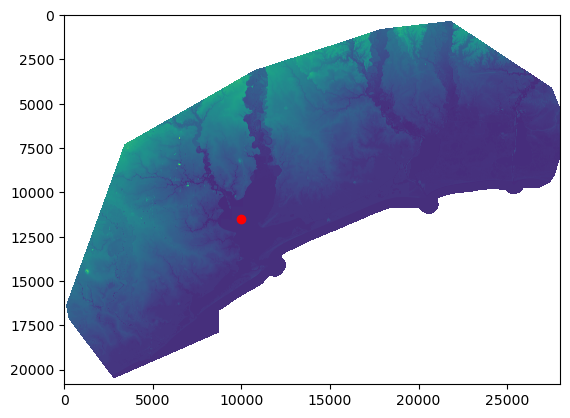

In [4]:
ocean_pixel = (11500, 10000)  # row, col

plt.imshow(dem)
plt.plot(ocean_pixel[1], ocean_pixel[0], "ro")
plt.show()

### run c-HAND

In [5]:
%%time

ike_gage = 3.8 # meters
inun_ike = c_hand(dem, ike_gage, ocean_pixel)

CPU times: user 8.16 s, sys: 7.96 s, total: 16.1 s
Wall time: 20.5 s


### Crop out coastline

In [6]:
# read geojson or shapefile of domain with coastline
aoi_coast = gpd.read_file(join(data_dir, "aoi_coastline.geojson"))
aoi_coast_mask = geometry_mask(
    aoi_coast.geometry, inun_ike.shape, dem_profile["transform"]
)

# crop array
inun_ike[aoi_coast_mask == True] = np.nan
inun_ike[inun_ike == 0] = np.nan

### Show coastal inundation map

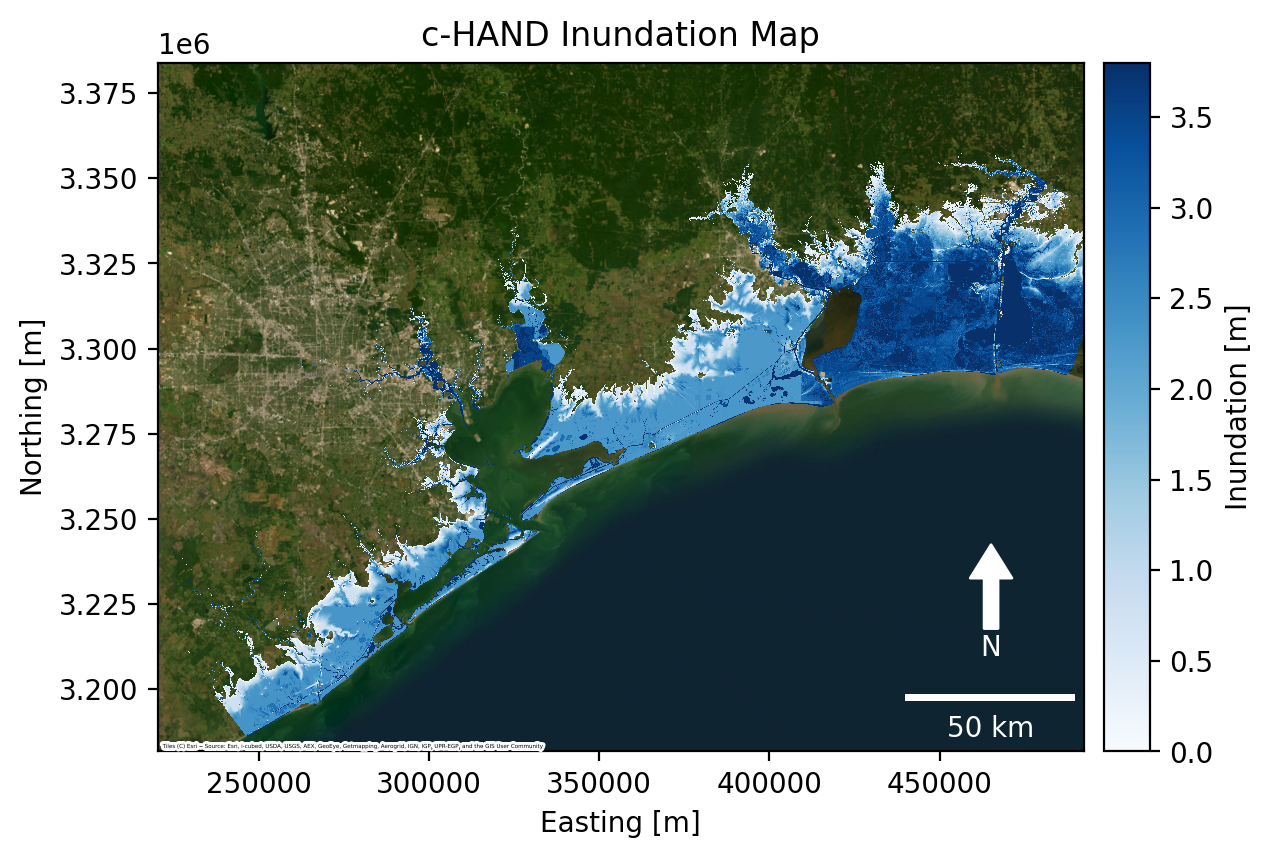

In [7]:
plt.close("all")
fig, ax = plt.subplots(dpi=200)

# show inundation map
im = ax.imshow(
    inun_ike,
    extent=plotting_extent(inun_ike, dem_profile["transform"]),
    cmap="Blues",
    vmin=0,
    vmax=ike_gage,
    interpolation="nearest",
    zorder=2,
)

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
fig.colorbar(im, cax=cax, label="Inundation [m]")

# add basemap
cx.add_basemap(
    ax,
    crs=dem_profile["crs"],
    source=cx.providers.Esri.WorldImagery,
    zoom=10,
    attribution_size=2,
    zorder=1,
)

# add scalebar
ax.add_artist(ScaleBar(1, box_alpha=0, location="lower right", color="white"))

# add north arrow
x, y, arrow_length = 0.9, 0.3, 0.15
ax.annotate(
    "N",
    color="white",
    xy=(x, y),
    xytext=(x, y - arrow_length),
    arrowprops=dict(
        facecolor="white", edgecolor="white", width=5, headwidth=15
    ),
    ha="center",
    va="center",
    fontsize=10,
    xycoords=ax.transAxes,
)

# add labels
ax.set(
    title="c-HAND Inundation Map",
    xlabel="Easting [m]",
    ylabel="Northing [m]",
)

plt.show()

# fig.savefig(join(data_dir, "c-HAND.png"), dpi=300, bbox_inches="tight")

### Write inundation array to GeoTIFF

In [8]:
# write to raster, including mask if applicable
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    dem_profile["compress"] = "lzw"
    with rio.open(join(data_dir, "inun_ike.tif"), "w", **dem_profile) as ds_out:
        ds_out.write(inun_ike, 1)
        if isinstance(inun_ike, np.ma.MaskedArray):
            msk = (~inun_ike.mask * 255).astype("uint8")
            ds_out.write_mask(msk)